# Setup

In [44]:
import matplotlib.pyplot as plt
import seaborn as sns
import pandas as pd
import numpy as np
import scipy.stats as stats
import pingouin as pg
from pingouin import pairwise_gameshowell

# File import

In [45]:
cleavage = pd.read_excel(
    'Cleavage positions.xlsx', 
    sheet_name = 'wtCas9_sgRNA1', 
    skiprows = 1, 
   # index_col = [0])
).replace('None', np.nan)
no_log = cleavage.drop('cleavage_rate_log', axis = 'columns').drop('cleavage_rate_log_unc', axis = 'columns').drop('descriptor', axis = 'columns')
cleavage_rate = cleavage.loc[:, 'sequence':'cleavage_rate_log_unc'].drop('descriptor', axis = 'columns')

In [46]:
cleavage_rate

,sequence,cleavage_rate_log,cleavage_rate_log_unc
0,TTTAGACCCATAAAGATAAGACGCTGG,-2.977889,0.123122
1,TTTAGACGCTTAAAGATGAGAGGCTGG,-4.521508,0.128360
2,TTTAGGAACGCATAAAGATGAGACGCTGG,-0.844324,0.081633
3,TTTAGACGCATAAAGATGAGACGCGTCCA,-5.164886,2.005390
4,TTTAGACGCATAAAGATGAGACGCGTCCG,-5.822938,0.262783
...,...,...,...
9952,TTTAGACGCACAAAGATGACACGCTGG,-4.865986,0.295606
9953,TTTAGACGCATAAAGATGACACGCTGG,-3.723213,0.077379
9954,AGCGTTGACGCATAAAGATGAGACGCTGG,-0.863172,0.065296
9955,TTTAGACGCATAAAGATGAGACGCCGC,-5.104417,0.125504


# Features of the main sequence

In [47]:
pam_cas12 = 'TTTA'
pam_cas9 = 'TGG'
sequence = 'GACGCATAAAGATGAGACGC'

In [48]:
OG_seq = cleavage[cleavage['sequence'] == pam_cas12 + sequence + pam_cas9]
OG_seq

,sequence,descriptor,cleavage_rate_log,cleavage_rate_log_unc,L_12s,L_3m,L_10m,L_100m,L_300m,L_1000m,L_3000m,R_12s,R_3m,R_10m,R_100m,R_300m,R_1000m,R_3000m
4819,TTTAGACGCATAAAGATGAGACGCTGG,pamTGG,-1.032424,0.075517,3.0,3.0,3.0,3.0,3.0,3.0,NaN,3.0,3.0,3.0,3.0,3.0,3.0,NaN


# Creating Filters

In [49]:
def create_mismatches(sequence, pam_5_end='', pam_3_end=''):
    # When given a sequence, will generate all possible single and double mismatches
    # Can also add two PAMs on different ends
    mis_list = []
    
    # Single mismatches
    for i in range(len(sequence)):
        for base in 'ACGT':
            new_seq = pam_5_end + sequence[:i] + base + sequence[i+1:] + pam_3_end
            #adds the base into a defined sequence, skipping the place where it gets added, that way simulating a mismatch
            mis_list.append(new_seq)

            # Double mismatches
            for j in range(i+1, len(sequence)):
                for base2 in 'ACGT':
                    new_seq2 = pam_5_end + sequence[:i] + base + sequence[i+1:j] + base2 + sequence[j+1:] + pam_3_end
                    mis_list.append(new_seq2)
                    
                    # Triple mismatches
                    #for f in range(i+2, len(sequence)):
                        #for base3 in 'ACGT':
                            #new_seq3 = pam_5_end + sequence[:i] + base + sequence[i+1:j] + base2 + sequence[j+1:f] + base3 + sequence[f:] + pam_3_end
                            #mis_list.append(new_seq3)
    return mis_list
   
mismatch = create_mismatches(sequence, 'TTTA', 'TGG')

In [50]:
def create_del(sequence, pam_5_end = '', pam_3_end = ''):
    # When given a sequence, will generate all possible single, double, and triple deletions
    del_list = []
    
    # Single deletions
    for i in range(len(sequence)):
        new_seq = sequence[:i] + sequence[i+1:]
        del_list.append(new_seq)

        # Double deletions
        for j in range(i+1, len(sequence)):
            new_seq = sequence[:i] + sequence[i+1:j] + sequence[j+1:]
            #skipps one base, that way making a deletion
            del_list.append(new_seq)

            # Triple deletions
            #for k in range(j+1, len(sequence)):
                #new_seq = sequence[:i] + sequence[i+1:j] + sequence[j+1:k] + sequence[k+1:]
                #del_list.append(new_seq)

    return del_list

dels = create_del(sequence, 'TTTA', 'TGG')

In [51]:
def create_ins(sequence, pam_5_end = '', pam_3_end = ''):
    # When given a sequence, will generate all possible single, double, and triple insertions
    # Can also add two PAMs on different ends
    ins_list = []
    
    #Single insertion
    for i in range(len(sequence)+1):
        for base1 in 'ACGT':
            new_seq = pam_5_end + sequence[:i] + base1 + sequence[i:] + pam_3_end
            #adds a base 
            ins_list.append(new_seq)
            
            #Double insertion
            for j in range(i+1, len(sequence)+2):
                for base2 in 'ACGT':
                    new_seq2 = pam_5_end + sequence[:i] + base1 + sequence[i:j] + base2 + sequence[j:] + pam_3_end
                    ins_list.append(new_seq2)
                    
                    #Triple insertion
                    #for k in range(j+1, len(sequence)+3):
                        #for base3 in 'ACGT':
                            #new_seq3 = pam_5_end + sequence[:i] + base1 + sequence[i:j] + base2 + sequence[j:k] + base3 + sequence[k:] + pam_3_end
                            #ins_list.append(new_seq3)
    return ins_list

ins = create_ins(sequence, 'TTTA', 'TGG')

In [52]:
def create_small_ins(sequence, pam_5_end = '', pam_3_end = ''):
    #Will create insertions in a given sequence only at position 3 and 4 from the 3' end
    ins_list = []
    
    #Single insertion
    for i in range(-3, -1):
        for base1 in 'ACGT':
            new_seq = pam_5_end + sequence[:i] + base1 + sequence[i:] + pam_3_end
            ins_list.append(new_seq)
            
            #Double insertion
          #  for j in range(i+1, i+2):
           #     for base2 in 'ACGT':
            #        new_seq2 = pam_5_end + sequence[:i] + base1 + sequence[i:j] + base2 + sequence[j:] + pam_3_end
             #       ins_list.append(new_seq2)
                    
                    #Triple insertion
                    #for k in range(j+1, len(sequence)+3):
                        #for base3 in 'ACGT':
                            #new_seq3 = pam_5_end + sequence[:i] + base1 + sequence[i:j] + base2 + sequence[j:k] + base3 + sequence[k:] + pam_3_end
                            #ins_list.append(new_seq3)
    return ins_list

small_ins = create_small_ins(sequence, 'TTTA', 'TGG')

In [53]:
def double_base(sequence, pam_5_end = '', pam_3_end = '', compare = ''):
    double_seq = []
    for x in range(0, len(sequence)):
        new_seq = pam_5_end + sequence[:x+1]+sequence[x:] + pam_3_end
        double_seq.append(new_seq)
        
    if compare == 'yes':
        double_seq.append(double_seq[-1])
    return double_seq

double_base = double_base(sequence, 'TTTA', 'TGG', compare = 'yes')

In [54]:
def triple_base(sequence, pam_5_end = '', pam_3_end = '', compare = ''):
    triple_seq = []
    for x in range(0, len(sequence)):
        new_seq = pam_5_end + sequence[:x+1] + sequence[x:x+1] + sequence[x:] + pam_3_end
        triple_seq.append(new_seq)
        
    if compare == 'yes':
        triple_seq.append(triple_seq[-1])
    
    return triple_seq

triple_bases = triple_base(sequence, 'TTTA', 'TGG', compare = 'yes')

In [55]:
def rep2_tribase(sequence, pam_5_end = '', pam_3_end = ''):
    triple_seq = []
    for x in range(0, len(sequence)):
        new_seq = pam_5_end + sequence[:x+2]+sequence[x:] + pam_3_end
        triple_seq.append(new_seq)
        
    return triple_seq

rep_base = rep2_tribase(sequence, 'TTTA', 'TGG')

In [56]:
def A_base(sequence, pam_5_end = '', pam_3_end = ''):
    A_seq = []
    for x in range(0, len(sequence)+1):
        new_seq = pam_5_end + sequence[:x]+ 'A' +sequence[x:] + pam_3_end
        A_seq.append(new_seq)
        
    return A_seq

A_ins = A_base(sequence, 'TTTA', 'TGG')

In [57]:
def C_base(sequence, pam_5_end = '', pam_3_end = ''):
    C_seq = []
    for x in range(0, len(sequence)+1):
        new_seq = pam_5_end + sequence[:x]+ 'C' +sequence[x:] + pam_3_end
        C_seq.append(new_seq)
        
    return C_seq

C_ins = C_base(sequence, 'TTTA', 'TGG')

In [58]:
def G_base(sequence, pam_5_end = '', pam_3_end = ''):
    G_seq = []
    for x in range(0, len(sequence)+1):
        new_seq = pam_5_end + sequence[:x]+ 'G' +sequence[x:] + pam_3_end
        G_seq.append(new_seq)
        
    return G_seq

G_ins = G_base(sequence, 'TTTA', 'TGG')

In [59]:
def T_base(sequence, pam_5_end = '', pam_3_end = ''):
    T_seq = []
    for x in range(0, len(sequence)+1):
        new_seq = pam_5_end + sequence[:x]+ 'T' +sequence[x:] + pam_3_end
        T_seq.append(new_seq)
        
    return T_seq

T_ins = T_base(sequence, 'TTTA', 'TGG')

In [60]:
def A2_base(sequence, pam_5_end = '', pam_3_end = ''):
    A_seq = []
    for x in range(0, len(sequence)+1):
        new_seq = pam_5_end + sequence[:x]+ 'AA' +sequence[x:] + pam_3_end
        A_seq.append(new_seq)
        
    return A_seq

A2_ins = A2_base(sequence, 'TTTA', 'TGG')

In [61]:
def C2_base(sequence, pam_5_end = '', pam_3_end = ''):
    C_seq = []
    for x in range(0, len(sequence)+1):
        new_seq = pam_5_end + sequence[:x]+ 'CC' +sequence[x:] + pam_3_end
        C_seq.append(new_seq)
        
    return C_seq

C2_ins = C2_base(sequence, 'TTTA', 'TGG')

In [62]:
def G2_base(sequence, pam_5_end = '', pam_3_end = ''):
    G_seq = []
    for x in range(0, len(sequence)+1):
        new_seq = pam_5_end + sequence[:x]+ 'GG' +sequence[x:] + pam_3_end
        G_seq.append(new_seq)
        
    return G_seq

G2_ins = G2_base(sequence, 'TTTA', 'TGG')

In [63]:
def T2_base(sequence, pam_5_end = '', pam_3_end = ''):
    T_seq = []
    for x in range(0, len(sequence)+1):
        new_seq = pam_5_end + sequence[:x]+ 'TT' +sequence[x:] + pam_3_end
        T_seq.append(new_seq)
        
    return T_seq

T2_ins = T2_base(sequence, 'TTTA', 'TGG')

In [64]:
def AN_base(sequence, pam_5_end = '', pam_3_end = ''):
    T_seq = []
    for x in range(0, len(sequence)+1):
        for base in 'ACGT':
            new_seq = pam_5_end + sequence[:x]+ f'A{base}' +sequence[x:] + pam_3_end
            T_seq.append(new_seq)
        
    return T_seq

#Was too lazy to change the list names inside these functions, but since they have no impact on functionality, they might be changed some time later
AN_ins = AN_base(sequence, 'TTTA', 'TGG')

In [65]:
def CN_base(sequence, pam_5_end = '', pam_3_end = ''):
    T_seq = []
    for x in range(0, len(sequence)+1):
        for base in 'ACGT':
            new_seq = pam_5_end + sequence[:x]+ f'C{base}' +sequence[x:] + pam_3_end
            T_seq.append(new_seq)
        
    return T_seq

CN_ins = CN_base(sequence, 'TTTA', 'TGG')

In [66]:
def GN_base(sequence, pam_5_end = '', pam_3_end = ''):
    T_seq = []
    for x in range(0, len(sequence)+1):
        for base in 'ACGT':
            new_seq = pam_5_end + sequence[:x]+ f'G{base}' +sequence[x:] + pam_3_end
            T_seq.append(new_seq)
        
    return T_seq

GN_ins = GN_base(sequence, 'TTTA', 'TGG')

In [67]:
def TN_base(sequence, pam_5_end = '', pam_3_end = ''):
    T_seq = []
    for x in range(0, len(sequence)+1):
        for base in 'ACGT':
            new_seq = pam_5_end + sequence[:x]+ f'T{base}' +sequence[x:] + pam_3_end
            T_seq.append(new_seq)
        
    return T_seq

TN_ins = TN_base(sequence, 'TTTA', 'TGG')

# Filtering Data

In [68]:
#DataFrame with all possible insertions
ins_df = pd.DataFrame(
    columns=['sequence',
             'L_12s', 'L_3m', 'L_10m', 'L_100m', 'L_300m', 'L_1000m', 'L_3000m',
             'R_12s', 'R_3m', 'R_10m', 'R_100m', 'R_300m', 'R_1000m', 'R_3000m']
)

#Dataframe with all possible insertions in 2X3 and 3X4
small_ins_df = pd.DataFrame(
    columns=['sequence',
             'L_12s', 'L_3m', 'L_10m', 'L_100m', 'L_300m', 'L_1000m', 'L_3000m',
             'R_12s', 'R_3m', 'R_10m', 'R_100m', 'R_300m', 'R_1000m', 'R_3000m']
)
#dataframe with mismatches
mis_df = pd.DataFrame(
    columns=['sequence',
             'L_12s', 'L_3m', 'L_10m', 'L_100m', 'L_300m', 'L_1000m', 'L_3000m',
             'R_12s', 'R_3m', 'R_10m', 'R_100m', 'R_300m', 'R_1000m', 'R_3000m']
)
#dataframe with deletions
del_df = pd.DataFrame(
    columns=['sequence',
             'L_12s', 'L_3m', 'L_10m', 'L_100m', 'L_300m', 'L_1000m', 'L_3000m',
             'R_12s', 'R_3m', 'R_10m', 'R_100m', 'R_300m', 'R_1000m', 'R_3000m']
)
#dataframe with insertions of a single base, that shares the identity of an adjecent base
doubles_df = pd.DataFrame(
    columns = ['sequence', 'cleavage_rate_log', 'cleavage_rate_log_unc']
)
#dataframe with insertions of two bases, that share the identity of an adjecent base
triples_df = pd.DataFrame(
    columns = ['sequence', 'cleavage_rate_log', 'cleavage_rate_log_unc']
)
#dataframe with insertions of a two bases, that share the identity of two adjecent bases
rep2_df = pd.DataFrame(
    columns = ['sequence', 'cleavage_rate_log', 'cleavage_rate_log_unc']
)
#dataframe with insertions of just A
A_df = pd.DataFrame(
    columns = ['sequence', 'cleavage_rate_log', 'cleavage_rate_log_unc']
)
#dataframe with insertions of just C
C_df = pd.DataFrame(
    columns = ['sequence', 'cleavage_rate_log', 'cleavage_rate_log_unc']
)
#dataframe with insertions of just G
G_df = pd.DataFrame(
    columns = ['sequence', 'cleavage_rate_log', 'cleavage_rate_log_unc']
)
#dataframe with insertions of just T
T_df = pd.DataFrame(
    columns = ['sequence', 'cleavage_rate_log', 'cleavage_rate_log_unc']
)
#dataframe with insertions of two As
Ad_df = pd.DataFrame(
    columns = ['sequence', 'cleavage_rate_log', 'cleavage_rate_log_unc']
)
#dataframe with insertions of two Cs
Cd_df = pd.DataFrame(
    columns = ['sequence', 'cleavage_rate_log', 'cleavage_rate_log_unc']
)
#dataframe with insertions of two Gs
Gd_df = pd.DataFrame(
    columns = ['sequence', 'cleavage_rate_log', 'cleavage_rate_log_unc']
)
#dataframe with insertions of two Ts
Td_df = pd.DataFrame(
    columns = ['sequence', 'cleavage_rate_log', 'cleavage_rate_log_unc']
)
#dataframe with insertions of two bases, the first being A, the other- any base
AN_df = pd.DataFrame(
    columns = ['sequence', 'cleavage_rate_log', 'cleavage_rate_log_unc']
)
#dataframe with insertions of two bases, the first being C, the other- any base
CN_df = pd.DataFrame(
    columns = ['sequence', 'cleavage_rate_log', 'cleavage_rate_log_unc']
)
#dataframe with insertions of two bases, the first being G, the other- any base
GN_df = pd.DataFrame(
    columns = ['sequence', 'cleavage_rate_log', 'cleavage_rate_log_unc']
)
#dataframe with insertions of two bases, the first being T, the other- any base
TN_df = pd.DataFrame(
    columns = ['sequence', 'cleavage_rate_log', 'cleavage_rate_log_unc']
)
#quatro_df = pd.DataFrame(
 #   columns = ['sequence', 'cleavage_rate_log', 'cleavage_rate_log_unc']
#)

In [69]:
#Fill the empty dataframes with data from created filters
#If running this cell with triple mismatches and more features, be ready to wait for at least 5 minutes

#for seq in ins:
#    matching_rows = no_log[no_log['sequence'] == seq]
#    ins_df = pd.concat([ins_df, matching_rows])

for seq in small_ins:
    matching_rows = no_log[no_log['sequence'] == seq]
    small_ins_df = pd.concat([small_ins_df, matching_rows])
    
#for seq in dels:
 #   matching_rows = no_log[no_log['sequence'] == seq]
  #  del_df = pd.concat([del_df, matching_rows])
    
#for seq in mismatch:
 #   matching_rows = no_log[no_log['sequence'] == seq]
  #  mis_df = pd.concat([mis_df, matching_rows])
    
for seq in double_base:
    matching_rows = cleavage_rate[cleavage_rate['sequence'] == seq]
    doubles_df = pd.concat([doubles_df, matching_rows])
    
for seq in triple_bases:
    matching_rows = cleavage_rate[cleavage_rate['sequence'] == seq]
    triples_df = pd.concat([triples_df, matching_rows])
    
for seq in rep_base:
    matching_rows = cleavage_rate[cleavage_rate['sequence'] == seq]
    rep2_df = pd.concat([rep2_df, matching_rows])
    
for seq in A_ins:
    matching_rows = cleavage_rate[cleavage_rate['sequence'] == seq]
    A_df = pd.concat([A_df, matching_rows])
    
for seq in C_ins:
    matching_rows = cleavage_rate[cleavage_rate['sequence'] == seq]
    C_df = pd.concat([C_df, matching_rows])
    
for seq in G_ins:
    matching_rows = cleavage_rate[cleavage_rate['sequence'] == seq]
    G_df = pd.concat([G_df, matching_rows])
    
for seq in T_ins:
    matching_rows = cleavage_rate[cleavage_rate['sequence'] == seq]
    T_df = pd.concat([T_df, matching_rows])

for seq in A2_ins:
    matching_rows = cleavage_rate[cleavage_rate['sequence'] == seq]
    Ad_df = pd.concat([Ad_df, matching_rows])
    
for seq in C2_ins:
    matching_rows = cleavage_rate[cleavage_rate['sequence'] == seq]
    Cd_df = pd.concat([Cd_df, matching_rows])
    
for seq in G2_ins:
    matching_rows = cleavage_rate[cleavage_rate['sequence'] == seq]
    Gd_df = pd.concat([Gd_df, matching_rows])
    
for seq in T2_ins:
    matching_rows = cleavage_rate[cleavage_rate['sequence'] == seq]
    Td_df = pd.concat([Td_df, matching_rows])

for seq in AN_ins:
    matching_rows = cleavage_rate[cleavage_rate['sequence'] == seq]
    AN_df = pd.concat([AN_df, matching_rows])
    
for seq in CN_ins:
    matching_rows = cleavage_rate[cleavage_rate['sequence'] == seq]
    CN_df = pd.concat([CN_df, matching_rows])
    
for seq in GN_ins:
    matching_rows = cleavage_rate[cleavage_rate['sequence'] == seq]
    GN_df = pd.concat([Gd_df, matching_rows])
    
for seq in TN_ins:
    matching_rows = cleavage_rate[cleavage_rate['sequence'] == seq]
    TN_df = pd.concat([TN_df, matching_rows])
#for seq in quatro_bases:
  #  matching_rows = cleavage_rate[cleavage_rate['sequence'] == seq]
   # quatro_df = pd.concat([quatro_df, matching_rows])

# Visualization of Cut sites at one time point 

In [70]:
def swarm_data(df, column):
    
    #Will put the values from the column into a seperate dataframe based on the position of the bases and what base it is
    
    new_df = pd.DataFrame()

    data_df = df.dropna(subset=[column])

    for x in range(-7, -5):
        for base in 'ACGT':
            mask = (data_df['sequence'].str[x] == base)
            #will check each base in each of the defined positions 
            new_column_name = f'{abs(x)-3}{base}{abs(x)-4}'
            #names the column
            new_df[new_column_name] = data_df.loc[mask, column].reset_index(drop=True)
            #drop the data into the labeled column
    new_df = new_df.fillna(0)

    return new_df

In [71]:
def nona_count(df, column):
    
    #Counts how many non NaN values are in each column 
    
    new_df = pd.DataFrame()

    data_df = df.dropna(subset=[column])

    for x in range(-7, -5):
        for base in 'ACGT':
            mask = (data_df['sequence'].str[x] == base)
            new_column_name = f'{abs(x)-3}{base}{abs(x)-4}'
            new_df[new_column_name] = data_df.loc[mask, column].reset_index(drop=True)
        
    nona_count = new_df.notna().sum()
    return nona_count

In [72]:
def mean_df(df, column):
    
    #Will create a dataframe of average values for each column. This later is used in graph drawing
    
    mean_df = pd.DataFrame()

    for x in range(-7, -5):  #For each position 3 and 4
        for base in 'ACGT':  #Take a base
            notna_df = df[df[column].notna()]   #Filter the data that this column contains no NaN values
            average_cut = notna_df[notna_df['sequence'].str[x] == base][column].mean()   #find the sequences that contain that specific base in that specific position in that column
            column_name = f'{abs(x)-3}{base}{abs(x)-4}'   #Name the column of the empty dataframe
            mean_df.loc[0, column_name] = average_cut
    
    return mean_df

In [73]:
def mean_swarm(swarm, column, save = '', name = 'swarm with mean'):    
    
    #Will draw a strip plot of DNA cut sites, where a distribution of an average cut location based on the base in a certain position
    #will be depicted
    
    fig = plt.figure(figsize=(10, 7))
    sns.stripplot(data=swarm_data(swarm, column), orient="v", palette="Set2", size = 16, dodge=False, alpha = 0.3)
    #plt.scatter(x = mean_df(swarm, column).columns, y = mean_df(swarm, column), marker = 'o', color = 'black', s = 10, zorder = 10)
    plt.ylim(2.8, 4.2)
    plt.axhline(2, color='grey', alpha = 0.5)
    plt.axhline(2.5, color='grey', alpha = 0.5, linestyle=':')
    plt.axhline(3, color='grey', alpha = 0.5)
    plt.axhline(3.5, color='grey', alpha = 0.5, linestyle=':')
    plt.axhline(4, color='grey', alpha = 0.5)
    plt.xlabel('Position of insertion')
    plt.ylabel('Median cut site after 1000 minutes of reaction')
    plt.title('Cut site position in sequences with a single insertion adjecent to a cannonical cut site')

    y_offset = 0.1
    for pos, count in enumerate(nona_count(swarm, column)):
        plt.text(pos - 0.2, 2.5 + y_offset, f'n = {count}')
    
    if save == 'yes':
        plt.savefig(f"PNG {name}.png")
        plt.savefig(f'SVG {name}.svg', format='svg', bbox_inches='tight')

In [74]:
swarm_data(small_ins_df, 'L_1000m')

,4A3,4C3,4G3,4T3,3A2,3C2,3G2,3T2
0,3.09,4.0,0,4.0,4.0,3.09,3.52,4.0


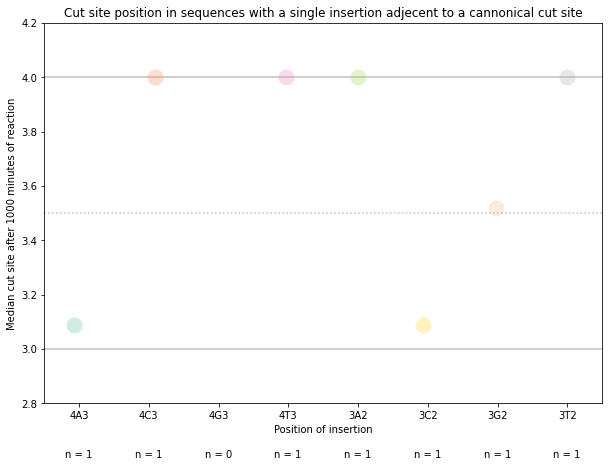

In [75]:
mean_swarm(small_ins_df, 'L_1000m')

In [76]:
small_ins_df

,sequence,L_12s,L_3m,L_10m,L_100m,L_300m,L_1000m,L_3000m,R_12s,R_3m,R_10m,R_100m,R_300m,R_1000m,R_3000m
1142,TTTAGACGCATAAAGATGAGAACGCTGG,NaN,NaN,3.5,3.45,3.33,3.09,NaN,NaN,NaN,NaN,3.0,3.0,3.0,NaN
9859,TTTAGACGCATAAAGATGAGACCGCTGG,NaN,NaN,NaN,NaN,NaN,4.0,NaN,NaN,NaN,NaN,3.0,3.0,3.0,NaN
9037,TTTAGACGCATAAAGATGAGAGCGCTGG,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
6355,TTTAGACGCATAAAGATGAGATCGCTGG,NaN,NaN,NaN,NaN,NaN,4.0,NaN,NaN,NaN,NaN,NaN,NaN,3.04,NaN
2445,TTTAGACGCATAAAGATGAGACAGCTGG,NaN,NaN,NaN,4.0,4.0,4.0,NaN,NaN,NaN,NaN,3.33,3.22,3.15,NaN
9859,TTTAGACGCATAAAGATGAGACCGCTGG,NaN,NaN,NaN,NaN,NaN,4.0,NaN,NaN,NaN,NaN,3.0,3.0,3.0,NaN
4850,TTTAGACGCATAAAGATGAGACGGCTGG,NaN,3.57,3.43,3.55,3.48,3.52,NaN,NaN,3.63,3.58,3.36,3.12,3.09,NaN
9406,TTTAGACGCATAAAGATGAGACTGCTGG,NaN,NaN,NaN,4.0,4.0,4.0,NaN,NaN,NaN,NaN,3.15,3.09,3.08,NaN


# Visualization of change in Cut site location based on time 

In [77]:
def cut_kinetics(
    df, 
    column_start_name = 'sequence', 
    column_end_name = 'L_3000m', 
    ylim = [2.7, 4.2], 
    figsize = [10, 5]):

    # Will draw the kinetics of a nuclease 
    
    
    titles = []
    row_end = len(df)
    for x in range(-7, -5):
        for base in 'ACGT':
            new_title = f'Insertion at position {abs(x)-3}{base}'
            titles.append(new_title)

    cut_df = df.loc[:, column_start_name:column_end_name]
    trans_df = cut_df.transpose()
    
    #plt.figure(figsize = figsize)
    for x in range(0, len(cut_df)):
        column = trans_df.columns[x]  # get the column name instead of its contents
        data = trans_df[column].iloc[1:].dropna()  # drop NaN values in the column
        plt.figure(figsize = figsize)
        plt.plot(data)
        plt.scatter(x = trans_df.iloc[1:, x].index, y = trans_df.iloc[1:, x])
        plt.title(titles[x], size = 17)
        plt.ylabel('Average cut site', size = 15)
        plt.xlabel('Time point', size = 15)
        plt.ylim(ylim)
        plt.axhline(2, color='grey', alpha = 0.5)
        plt.axhline(2.5, color='grey', alpha = 0.5, linestyle=':')
        plt.axhline(3, color='grey', alpha = 0.5)
        plt.axhline(3.5, color='grey', alpha = 0.5, linestyle=':')
        plt.axhline(4, color='grey', alpha = 0.5)
        #plt.legend()

C:\Users\justa\AppData\Local\Temp\ipykernel_32736\1120209009.py:27: MatplotlibDeprecationWarning: Support for passing numbers through unit converters is deprecated since 3.5 and support will be removed two minor releases later; use Axis.convert_units instead.
  plt.scatter(x = trans_df.iloc[1:, x].index, y = trans_df.iloc[1:, x])


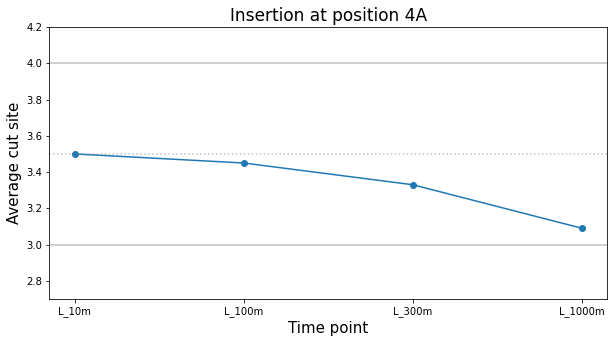

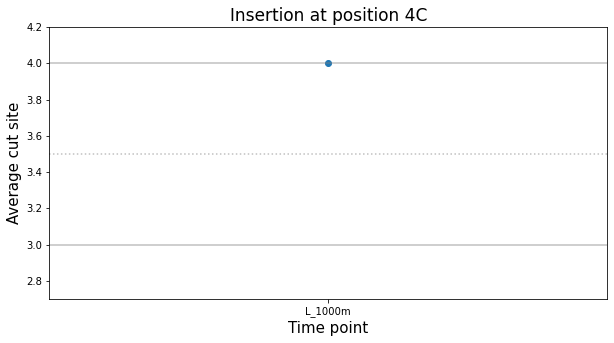

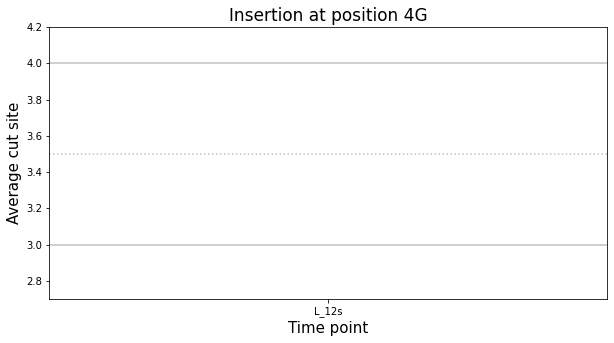

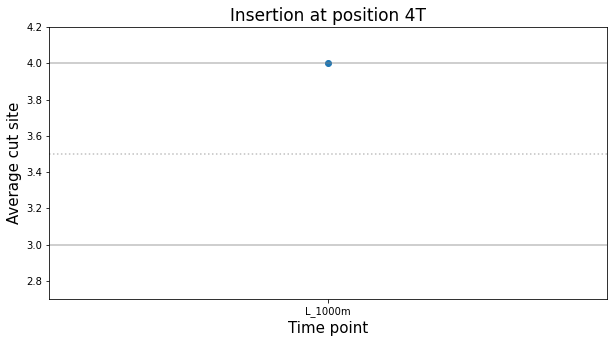

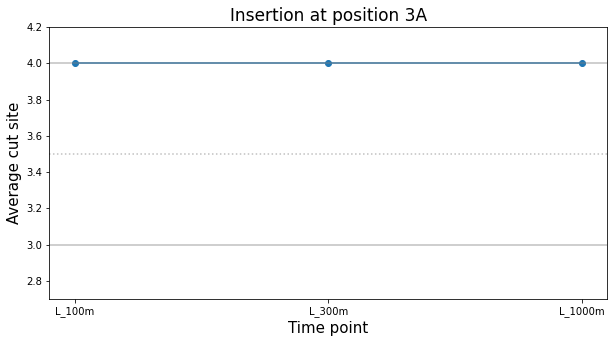

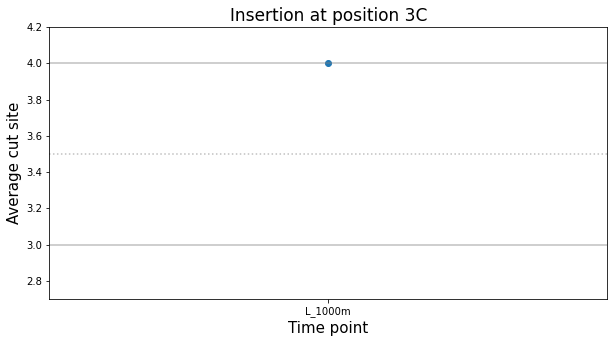

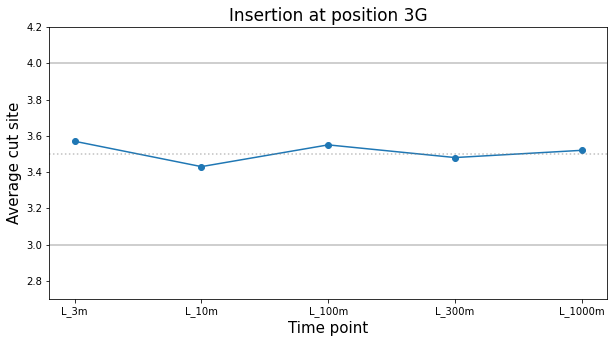

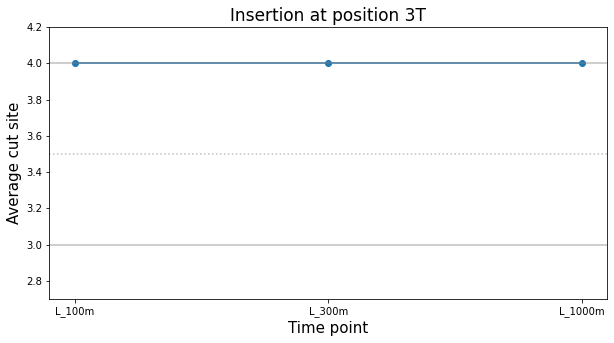

In [78]:
cut_kinetics(small_ins_df)

# Visualization of cut rate changes based on where a duplicated sequence is placed

In [79]:
cleavage[cleavage['sequence'].str.contains(f'^TTTA{sequence}TGG$')]

,sequence,descriptor,cleavage_rate_log,cleavage_rate_log_unc,L_12s,L_3m,L_10m,L_100m,L_300m,L_1000m,L_3000m,R_12s,R_3m,R_10m,R_100m,R_300m,R_1000m,R_3000m
4819,TTTAGACGCATAAAGATGAGACGCTGG,pamTGG,-1.032424,0.075517,3.0,3.0,3.0,3.0,3.0,3.0,NaN,3.0,3.0,3.0,3.0,3.0,3.0,NaN


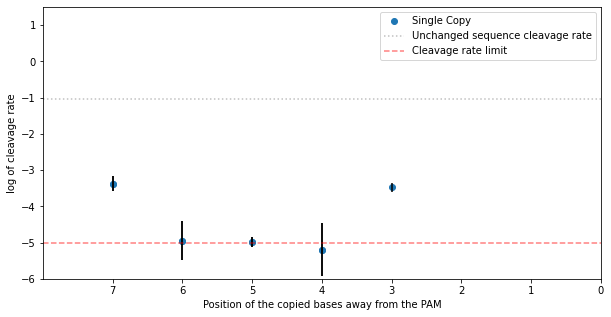

In [80]:
def cut_rate(df, x_axis='sequence', y_axis='cleavage_rate_log', y_error='cleavage_rate_log_unc', save = '', name = 'single cleavage rate'):
    
    #Creates the cleavage rate graph for a single data set 
    
    df = df.reset_index(drop=True)
    
    plt.figure(figsize=[10, 5])
    plt.scatter(x=df.loc[:, x_axis], y=df.loc[:, y_axis], label = 'Single Copy')#, color = 'blue')
    plt.errorbar(x=df.loc[:, x_axis], y=df.loc[:, y_axis], yerr=df.loc[:, y_error], fmt='none', color = 'black')
    
    plt.axhline(-1.032424, color='grey', alpha = 0.5, linestyle = ':', label = 'Unchanged sequence cleavage rate')
    plt.axhline(-5, color='red', alpha = 0.5, linestyle = '--', label = 'Cleavage rate limit')
    
    tick_labels = ['{}'.format(len(df)-2-x) for x in range(0, len(df))]
    plt.xticks(range(0, len(df)), tick_labels)
    
    plt.ylabel('log of cleavage rate')
    plt.xlabel('Position of the copied bases away from the PAM')
    #plt.title('Cleavage rate dependency on duplicated base insertions')
    
    plt.xlim(-1, len(df)-2)
    plt.ylim(-6, 1.5)
    plt.legend()
    
    if save == 'yes':
        plt.savefig(f"PNG {name}.png")
        plt.savefig(f'SVG {name}.svg', format='svg', bbox_inches='tight')

cut_rate(rep2_df)

,df_sequence,df_cleavage_rate_log,df_cleavage_rate_log_unc,df1_sequence,df1_cleavage_rate_log,df1_cleavage_rate_log_unc
0,TTTAGGACGCATAAAGATGAGACGCTGG,-1.050486,0.124431,TTTAGGGACGCATAAAGATGAGACGCTGG,-0.983604,0.064915
1,TTTAGAACGCATAAAGATGAGACGCTGG,-0.783183,0.052413,TTTAGAAACGCATAAAGATGAGACGCTGG,-0.651702,0.117339
2,TTTAGACCGCATAAAGATGAGACGCTGG,-0.847354,0.09288,TTTAGACCCGCATAAAGATGAGACGCTGG,-0.949995,0.056335
3,TTTAGACGGCATAAAGATGAGACGCTGG,-0.970217,0.069714,TTTAGACGGGCATAAAGATGAGACGCTGG,-1.391518,0.129381
4,TTTAGACGCCATAAAGATGAGACGCTGG,-2.40417,0.186061,TTTAGACGCCCATAAAGATGAGACGCTGG,-3.52043,0.132438
5,TTTAGACGCAATAAAGATGAGACGCTGG,-2.567038,0.097757,TTTAGACGCAAATAAAGATGAGACGCTGG,-3.960435,0.378329
6,TTTAGACGCATTAAAGATGAGACGCTGG,-3.68927,0.188533,TTTAGACGCATTTAAAGATGAGACGCTGG,-5.120128,0.122
7,TTTAGACGCATAAAAGATGAGACGCTGG,-1.64033,0.119706,TTTAGACGCATAAAAAGATGAGACGCTGG,-4.949561,0.532051
8,TTTAGACGCATAAAAGATGAGACGCTGG,-1.64033,0.119706,TTTAGACGCATAAAAAGATGAGACGCTGG,-4.949561,0.532051
9,TTTAGACGCATAAAAGATGAGACGCTGG,-1.64033,0.119706,TTTAGACGCATAAAAAGATGAGACGCTGG,-4.949561,0.532051


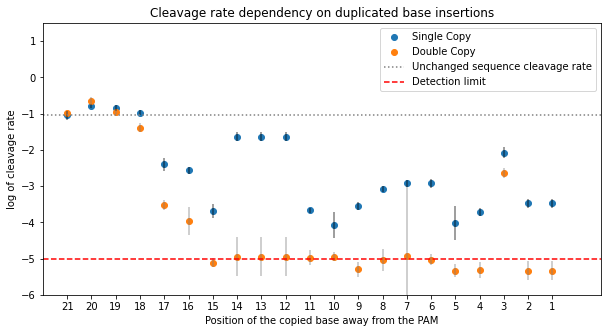

In [81]:
def cut_rate2(df, 
              df1, 
              legend1='Single Copy', 
              legend2='Double Copy', 
              legend3 = 'Unchanged sequence cleavage rate', 
              legend4 = 'Detection limit',
              save = '',
              name = 'sgRNA1'
):
    
    #Takes two dataframes and compares the cleavage rates between them also displaying the uncertainty
    
    df = df.reset_index(drop=True)
    df1 = df1.reset_index(drop=True)
    j_df = df.add_prefix('df_')
    j_df1 = df1.add_prefix('df1_')
    joint_df = pd.concat([j_df, j_df1], axis=1)
    
    x_data = df.index
    
    plt.figure(figsize=[10, 5])
    plt.scatter(x=x_data, y=joint_df.loc[:, 'df_cleavage_rate_log'], label=legend1)
    plt.scatter(x=x_data, y=joint_df.loc[:, 'df1_cleavage_rate_log'], label=legend2)
    
    # Add uncertainty bars
    plt.errorbar(x=x_data, y=joint_df.loc[:, 'df_cleavage_rate_log'], 
                 yerr=joint_df.loc[:, 'df_cleavage_rate_log_unc'], 
                 linestyle='None', color='black', alpha=0.5)
    plt.errorbar(x=x_data, y=joint_df.loc[:, 'df1_cleavage_rate_log'], 
                 yerr=joint_df.loc[:, 'df1_cleavage_rate_log_unc'], 
                 linestyle='None', color='grey', alpha=0.5)
    
    tick_labels = ['{}'.format(len(df)-x) for x in range(0, len(df))]
    plt.xticks(range(0, len(joint_df)), tick_labels)
    plt.ylabel('log of cleavage rate')
    plt.xlabel('Position of the copied base away from the PAM')
    plt.title('Cleavage rate dependency on duplicated base insertions')
    
    plt.axhline(-1.032424, color='grey', alpha=1, linestyle=':', label = legend3)
    plt.axhline(-5, color='red', alpha=1, linestyle='--', label = legend4)
    
    plt.xlim(-1, len(joint_df)+1)
    plt.ylim(-6, 1.5)
    plt.legend(loc='best')    
    
    if save == 'yes':
        plt.savefig(f"PNG {name} 2 dataframes.png")
        plt.savefig(f'SVG {name} 2 dataframes.svg', format='svg', bbox_inches='tight')
    
    return joint_df

cut_rate2(doubles_df, triples_df)

# Visualization of single copy cleavage rates compared to a single insertion

In [82]:
def cut_rate_table(df, 
                  df1, 
                  df2, 
                  df3, 
                  df4
):    
    df = df.reset_index(drop=True)
    df1 = df1.reset_index(drop=True)
    df2 = df2.reset_index(drop=True)
    df3 = df3.reset_index(drop=True)
    df4 = df4.reset_index(drop=True)
    j_df = df.add_prefix('df_')
    j_df1 = df1.add_prefix('df1_')
    j_df2 = df2.add_prefix('df2_')
    j_df3 = df3.add_prefix('df3_')
    j_df4 = df4.add_prefix('df4_')
    joint_df = pd.concat([j_df, j_df1, j_df2, j_df3, j_df4], axis=1)
    
    return joint_df

cut_rate_table(doubles_df, A_df, C_df, G_df, T_df)

,df_sequence,df_cleavage_rate_log,df_cleavage_rate_log_unc,df1_sequence,df1_cleavage_rate_log,df1_cleavage_rate_log_unc,df2_sequence,df2_cleavage_rate_log,df2_cleavage_rate_log_unc,df3_sequence,df3_cleavage_rate_log,df3_cleavage_rate_log_unc,df4_sequence,df4_cleavage_rate_log,df4_cleavage_rate_log_unc
0,TTTAGGACGCATAAAGATGAGACGCTGG,-1.050486,0.124431,TTTAAGACGCATAAAGATGAGACGCTGG,-0.860232,0.070048,TTTACGACGCATAAAGATGAGACGCTGG,-0.965152,0.070914,TTTAGGACGCATAAAGATGAGACGCTGG,-1.050486,0.124431,TTTATGACGCATAAAGATGAGACGCTGG,-0.909702,0.072015
1,TTTAGAACGCATAAAGATGAGACGCTGG,-0.783183,0.052413,TTTAGAACGCATAAAGATGAGACGCTGG,-0.783183,0.052413,TTTAGCACGCATAAAGATGAGACGCTGG,-0.888297,0.070814,TTTAGGACGCATAAAGATGAGACGCTGG,-1.050486,0.124431,TTTAGTACGCATAAAGATGAGACGCTGG,-0.715116,0.057382
2,TTTAGACCGCATAAAGATGAGACGCTGG,-0.847354,0.09288,TTTAGAACGCATAAAGATGAGACGCTGG,-0.783183,0.052413,TTTAGACCGCATAAAGATGAGACGCTGG,-0.847354,0.09288,TTTAGAGCGCATAAAGATGAGACGCTGG,-0.864601,0.114652,TTTAGATCGCATAAAGATGAGACGCTGG,-0.880246,0.051385
3,TTTAGACGGCATAAAGATGAGACGCTGG,-0.970217,0.069714,TTTAGACAGCATAAAGATGAGACGCTGG,-0.868174,0.059393,TTTAGACCGCATAAAGATGAGACGCTGG,-0.847354,0.09288,TTTAGACGGCATAAAGATGAGACGCTGG,-0.970217,0.069714,TTTAGACTGCATAAAGATGAGACGCTGG,-0.991096,0.067434
4,TTTAGACGCCATAAAGATGAGACGCTGG,-2.40417,0.186061,TTTAGACGACATAAAGATGAGACGCTGG,-1.949019,0.132232,TTTAGACGCCATAAAGATGAGACGCTGG,-2.40417,0.186061,TTTAGACGGCATAAAGATGAGACGCTGG,-0.970217,0.069714,TTTAGACGTCATAAAGATGAGACGCTGG,-1.843321,0.124196
5,TTTAGACGCAATAAAGATGAGACGCTGG,-2.567038,0.097757,TTTAGACGCAATAAAGATGAGACGCTGG,-2.567038,0.097757,TTTAGACGCCATAAAGATGAGACGCTGG,-2.40417,0.186061,TTTAGACGCGATAAAGATGAGACGCTGG,-2.666399,0.087747,TTTAGACGCTATAAAGATGAGACGCTGG,-2.108415,0.062931
6,TTTAGACGCATTAAAGATGAGACGCTGG,-3.68927,0.188533,TTTAGACGCAATAAAGATGAGACGCTGG,-2.567038,0.097757,TTTAGACGCACTAAAGATGAGACGCTGG,-3.299166,0.240285,TTTAGACGCAGTAAAGATGAGACGCTGG,-3.451975,0.123495,TTTAGACGCATTAAAGATGAGACGCTGG,-3.68927,0.188533
7,TTTAGACGCATAAAAGATGAGACGCTGG,-1.64033,0.119706,TTTAGACGCATAAAAGATGAGACGCTGG,-1.64033,0.119706,TTTAGACGCATCAAAGATGAGACGCTGG,-3.465891,0.208658,TTTAGACGCATGAAAGATGAGACGCTGG,-3.069655,0.21742,TTTAGACGCATTAAAGATGAGACGCTGG,-3.68927,0.188533
8,TTTAGACGCATAAAAGATGAGACGCTGG,-1.64033,0.119706,TTTAGACGCATAAAAGATGAGACGCTGG,-1.64033,0.119706,TTTAGACGCATACAAGATGAGACGCTGG,-4.90411,0.495891,TTTAGACGCATAGAAGATGAGACGCTGG,-3.097212,0.103443,TTTAGACGCATATAAGATGAGACGCTGG,-3.725794,0.073032
9,TTTAGACGCATAAAAGATGAGACGCTGG,-1.64033,0.119706,TTTAGACGCATAAAAGATGAGACGCTGG,-1.64033,0.119706,TTTAGACGCATAACAGATGAGACGCTGG,-3.086712,0.252201,TTTAGACGCATAAGAGATGAGACGCTGG,-2.653195,0.234718,TTTAGACGCATAATAGATGAGACGCTGG,-2.167496,0.317


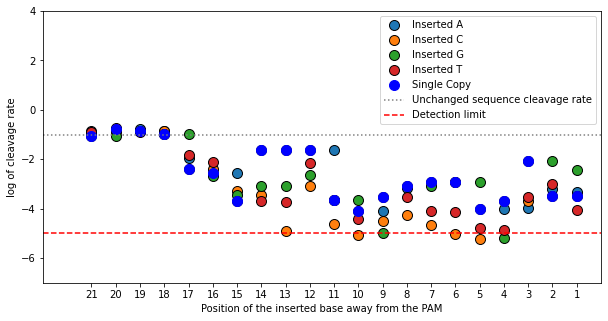

In [83]:
def cut_rate_comp(df, 
                  df1, 
                  df2, 
                  df3, 
                  df4, 
                  legend1='Single Copy', 
                  legend2 = 'Inserted A', 
                  legend3 = 'Inserted C', 
                  legend4 = 'Inserted G', 
                  legend5 = 'Inserted T', 
                  legend6 = 'Unchanged sequence cleavage rate', 
                  legend7 = 'Detection limit',
                  save = '',
                  name = 'sgRNA1'
):
    
    #Takes multiple dataframes and compares the cleavage rates between them
    
    joint_df = cut_rate_table(df, df1, df2, df3, df4)
    
    x_data = joint_df.index
    
    plt.figure(figsize=[10, 5])
    #plt.scatter(x=x_data, y=joint_df.loc[:19, 'df_cleavage_rate_log'], color = 'blue', label=legend1)
    plt.scatter(x=x_data, y=joint_df.loc[:, 'df1_cleavage_rate_log'], s = 100, edgecolor='black', label=legend2)
    plt.scatter(x=x_data, y=joint_df.loc[:, 'df2_cleavage_rate_log'], s = 100, edgecolor='black', label=legend3)
    plt.scatter(x=x_data, y=joint_df.loc[:, 'df3_cleavage_rate_log'], s = 100, edgecolor='black', label=legend4)
    plt.scatter(x=x_data, y=joint_df.loc[:, 'df4_cleavage_rate_log'], s = 100, edgecolor='black', label=legend5)
    plt.scatter(x=x_data, y=joint_df.loc[:, 'df_cleavage_rate_log'], s = 100, color = 'blue', label=legend1)
    
    tick_labels = ['{}'.format(len(df)-x) for x in range(0, len(df))]
    plt.xticks(range(0, len(joint_df)), tick_labels)
    plt.ylabel('log of cleavage rate')
    plt.xlabel('Position of the inserted base away from the PAM')
    #plt.title('Cleavage rate comparison between sequences with different insertions and sequences with a single duplicated base')
    
    plt.axhline(-1.032424, color='grey', alpha=1, linestyle=':', label = legend6)
    plt.axhline(-5, color='red', alpha=1, linestyle='--', label = legend7)
    
    plt.xlim(-2, len(joint_df))
    plt.ylim(-7, 4)
    plt.legend(loc='upper right')    
    
    if save == 'yes':
        plt.savefig(f"PNG {name} 2 dataframes.png")
        plt.savefig(f'SVG {name} 2 dataframes.svg', format='svg', bbox_inches='tight')

cut_rate_comp(doubles_df, A_df, C_df, G_df, T_df)

# Statistics

In [94]:
#collect all the data I need
table = cut_rate_table(rep2_df, AN_df, CN_df, GN_df, TN_df)

#remove the doubles_df
table_wide = table.loc[:, ['df1_cleavage_rate_log', 'df2_cleavage_rate_log', 'df3_cleavage_rate_log', 'df4_cleavage_rate_log']] 

#only doubles_df
dup_data = pd.DataFrame(table.loc[:, 'df_cleavage_rate_log']) 

#turn both wide dataframes into long formats
long = table_wide.melt(value_name='value').reset_index(drop = True)
long_dup = dup_data.melt(value_name='value').reset_index(drop = True)

#Mark what values need to be removed
values_to_exclude = long_dup['value'].unique()

# Filter out the rows from the bigger dataframe that match the values in the smaller dataframe
filtered_df = long[~long['value'].isin(values_to_exclude)].reset_index(drop = True)

#Concat the two dataframes
concated_df = pd.concat([filtered_df, long_dup], ignore_index=True).dropna()

# Create separate data arrays for each category
categories = concated_df['variable'].unique()
data_arrays = [concated_df[concated_df['variable'] == cat]['value'].values for cat in categories]

# Perform Welch ANOVA
f_statistic, p_value = stats.f_oneway(*data_arrays)

# Print the results
print("F-statistic:", f_statistic)
print("p-value:", p_value)

F-statistic: 1.2275869565736446
p-value: 0.3021927467593628


In [95]:
#Doubles and Triples dfs comparison

double_df = doubles_df.reset_index(drop=True)
triple_df= triples_df.reset_index(drop=True)
j_df = double_df.add_prefix('df_')
j_df1 = triple_df.add_prefix('df1_')
table_wide = pd.concat([j_df, j_df1], axis = 1)
table_wide = table_wide.loc[:, ['df_cleavage_rate_log', 'df1_cleavage_rate_log']]
table_long = table_wide.melt(value_name='value').dropna()

# Create separate data arrays for each category
categories = table_long['variable'].unique()
data_arrays = [table_long[table_long['variable'] == cat]['value'].values for cat in categories]

# Perform Welch ANOVA
f_statistic, p_value = stats.f_oneway(*data_arrays)

# Print the results
print("F-statistic:", f_statistic)
print("p-value:", p_value)

F-statistic: 11.569157578222956
p-value: 0.0015332361556366675
